<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/river_side_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 川の近く

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

### 地理マスタ

In [5]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


### river side マスタ

In [6]:
df_riverside_master = pd.read_csv(os.path.join(DIR_NAME, 'riverside.csv'))
print(df_riverside_master.shape)

(86, 3)


In [7]:
df_riverside_master.head()

,河川名,緯度,経度
0,多摩川01,35.618030,139.596382
1,多摩川02,35.614482,139.612325
2,多摩川03,35.611393,139.624757
3,多摩川04,35.611393,139.624757
4,多摩川05,35.604245,139.636329


In [8]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, method='min', param=3):
    _df_cat = df_facility
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            pass # print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

In [9]:
%%time
radius = 1.5
df_geo_master['川(数)'] = get_value_of_nearest_facility(df_geo_master, df_riverside_master, 'count', radius)
df_geo_master['川(距離)'] = get_value_of_nearest_facility(df_geo_master, df_riverside_master, 'min')

CPU times: user 15.3 s, sys: 172 ms, total: 15.5 s
Wall time: 21.9 s


In [10]:
df_geo_master['川(数)'] = df_geo_master['川(数)'].fillna(0).astype(int)
df_geo_master['川(距離)'] = df_geo_master['川(距離)'].fillna(9).round(3)

In [11]:
feature_list = [col for col in df_geo_master.columns if col.endswith(')')]

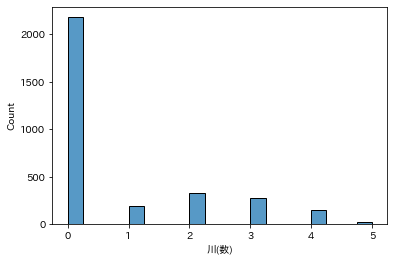

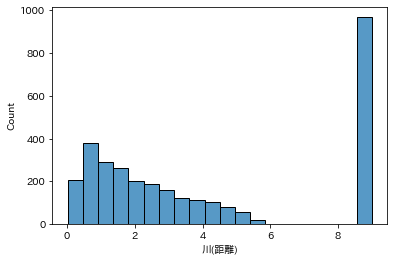

In [12]:
for feature in feature_list:
    sns.histplot(df_geo_master[feature], bins=20)
    plt.show()

In [13]:
df_geo_master[['town_id'] + feature_list].to_csv(os.path.join(DIR_NAME, 'river_side_score.csv'), index=False, encoding='utf-8_sig')